## So,

imagine you need to find a position of a point in space relative to some object on a photo.

In [17]:
import numpy as np
import cv2
from PIL import Image
import requests
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from io import BytesIO

In [18]:
def load_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return img
    
calibr_img = load_image("https://cdn.thingiverse.com/renders/0d/55/70/f9/e5/5ec4786b736c88242be5c905bde7f52f_preview_featured.jpg")

## Manual feature location

20mm x 20mm x 20mm cube


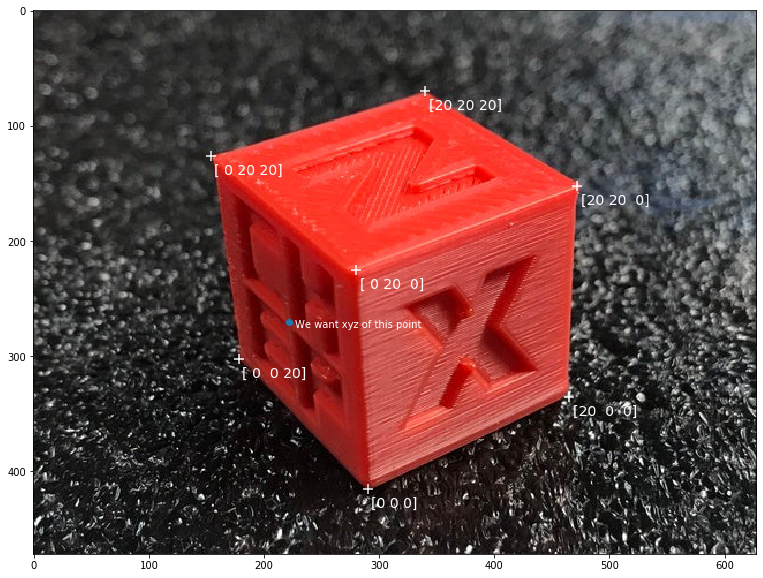

In [40]:
def plot_features(xyz_features, uv_features, bgr):
    plt.figure(figsize=(15,10))
    plt.imshow(bgr)
    for uv, xyz in zip(uv_features, xyz_features):
        u, v = uv
        plt.scatter(u, v, marker='+', s=100, c='w', alpha=0.975)
        plt.text(u+3, v+16, str(xyz), {'color':'w', 'size':14})
    

uv_features = np.array([[290, 415],
                        [465, 335],
                        [178, 302],
                        [280, 225],
                        [154, 126],
                        [472, 152],
                        [340, 70]])
xyz_features = np.array([[0, 0, 0],
                        [20, 0, 0],
                        [0, 0, 20],
                        [0, 20, 0],
                        [0, 20, 20],
                        [20, 20, 0],
                        [20, 20, 20]])

target_uv = np.array([[222], [270]])

print("20mm x 20mm x 20mm cube")
plot_features(xyz_features, uv_features, bgr=calibr_img)
plt.scatter(target_uv[0], target_uv[1]);
plt.text(target_uv[0]+5, target_uv[1]+5, 'We want xyz of this point', {'c':'w'});

## Pinhole camera projection model
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

In [20]:
def project(feat, rpy, xyz, fxfy):
    """
   feat: n features arranged in nx3 matrix;
   rpy: roll pitch yaw of the camera
   xyz: position of the camera
   fxfy: focal lengths x and y in camera
   """
    cx, cy = 0.5, 0.5
   
    xyz = np.array(xyz)
    r = Rotation.from_euler('zyx', rpy).as_matrix()
    t = feat.dot(r)+xyz
   
    u = fxfy[0]*t[:, 0]/t[:,2] + cx
    v = fxfy[1]*t[:, 1]/t[:,2] + cy

    return np.vstack([u,v]).T

This above is a function that maps xyz points to uv coordinates of the frame. It takes feauture xyz coordinates and maps them to uv picture coordinates according to the pinhole camera model. It makes camera transform matrix using camera orientation (roll, pitch yaw), camera position (x,y,z) and focal lengths fx, fy. The _'only'_ thing left is to optimize these unknown parameters to minimize the error of the function projection with respect to actual uvs of the features in the image. And this would probably not work, as it is a nonlinear crazy function what we try to optimize here and probably won't converge. So we won't even try.

**We do something different instead**:\
Lets squish 3x3 projection matrix and 3x4 camera transform matrix into a single 3x4 camera matrix mapping xyz -> uv and solve matrix equation instead. The downside - we will not directly infer intrinsic and extrinsic camera parameters, but get them all mixed together in a single matrix, but at leastsq (pun intended) we are guaranteed to get some solution on the quality of which we can judge. We have to juggle the vectors a bit, add ones padding, to make them fit tthe input of _numpy.linalg.lstsq:_

In [21]:
help(np.linalg.lstsq)

Help on function lstsq in module numpy.linalg:

lstsq(a, b, rcond='warn')
    Return the least-squares solution to a linear matrix equation.
    
    Solves the equation :math:`a x = b` by computing a vector `x` that
    minimizes the squared Euclidean 2-norm :math:`\| b - a x \|^2_2`.
    The equation may be under-, well-, or over-determined (i.e., the
    number of linearly independent rows of `a` can be less than, equal
    to, or greater than its number of linearly independent columns).
    If `a` is square and of full rank, then `x` (but for round-off error)
    is the "exact" solution of the equation.
    
    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K` columns
        of `b`.
    rcond : float, optional
        Cut-off ratio for small singular values of `a`.
       

In [22]:
a = np.hstack([xyz_features, np.ones([len(xyz_features),1])])
b = np.hstack([uv_features, np.ones([len(uv_features),1])])

a, b  #inputs to the solver, 1-padded to match dimensions

(array([[ 0.,  0.,  0.,  1.],
        [20.,  0.,  0.,  1.],
        [ 0.,  0., 20.,  1.],
        [ 0., 20.,  0.,  1.],
        [ 0., 20., 20.,  1.],
        [20., 20.,  0.,  1.],
        [20., 20., 20.,  1.]]),
 array([[290., 415.,   1.],
        [465., 335.,   1.],
        [178., 302.,   1.],
        [280., 225.,   1.],
        [154., 126.,   1.],
        [472., 152.,   1.],
        [340.,  70.,   1.]]))

In [23]:
res = np.linalg.lstsq(a, b, rcond=0.01)
T, residuals = res[:2]
print(f'projection matrix T: \n{T}')

projection matrix T: 
[[ 9.08125000e+00 -3.37500000e+00 -4.02149754e-17]
 [-4.81250000e-01 -9.00000000e+00 -3.32516515e-18]
 [-6.04375000e+00 -4.85000000e+00 -1.06212275e-17]
 [ 2.90750000e+02  4.05500000e+02  1.00000000e+00]]


## Now let's test it!

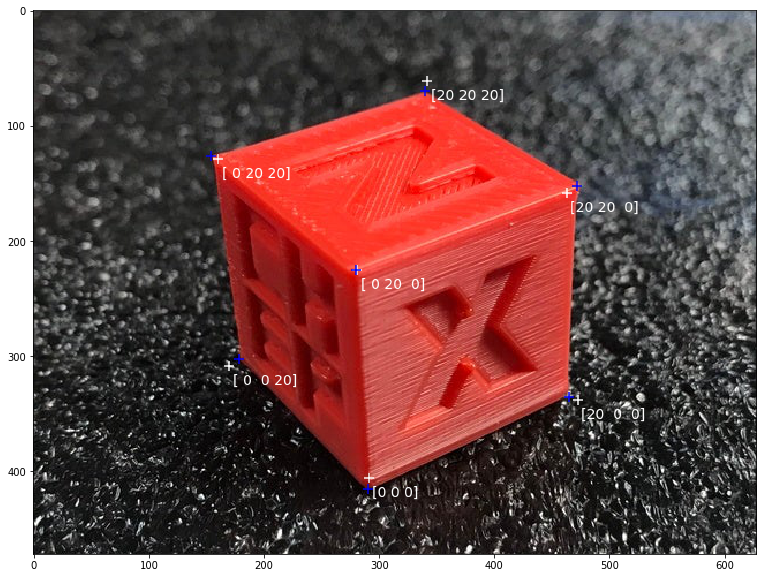

In [24]:
reprojected = np.dot(a, T)[:, :2]
plot_features(xyz_features, reprojected, bgr=calibr_img)
for uv, xyz in zip(uv_features, xyz_features):
    plt.scatter(uv[0], uv[1], marker='+', s=100, c='b', alpha=0.975)

Pretty good! But had we more fetures we may get a better result. Now let's try project other points for experiment. A scaled offset cube for example!

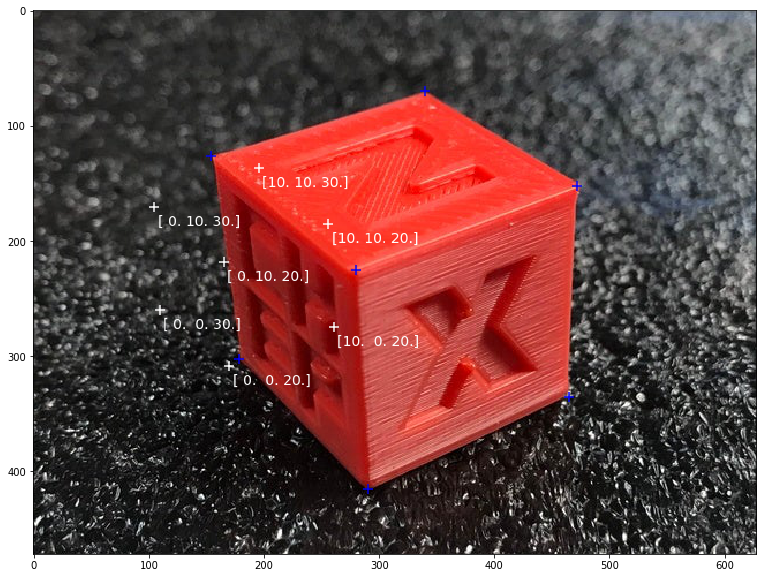

In [25]:
offset_features = xyz_features/2+np.array([0,0,20])
a = np.hstack([offset_features, np.ones([len(xyz_features),1])])
reprojected = np.dot(a, T)[:, :2]
plot_features(offset_features, reprojected, bgr=calibr_img)
for uv, xyz in zip(uv_features, xyz_features):
    plt.scatter(uv[0], uv[1], marker='+', s=100, c='b', alpha=0.975)

## Let's solve the inverse problem now and find xyz of a point based on the image

We have got a matrix projecting points in world space xyz to image plane uv: $[u, v] = T\cdot[x, y, z]$ Let's write it down in symbolic way as $T\cdot[x_{unknown}, y_{unknown}, z_{unknown}]-[u_{observed}, v_{observed}]=0$

In [26]:
import sympy as sym
s_T = sym.Matrix(T)
s_x, s_y, s_z = sym.symbols('x1,y1,z1')
s_xyz = sym.Matrix([[s_x], [s_y], [s_z], [1]]).T                 #Those we are looking for, xys of a point
s_uv = sym.Matrix([target_uv[0], target_uv[1], [1]]).T           #These are the observed uv of a point in image

A = s_xyz*s_T-s_uv
for _ in A:
    print(_)

9.08124999999999*x1 - 0.48125*y1 - 6.04375000000001*z1 + 68.7500000000001
-3.37500000000001*x1 - 8.99999999999999*y1 - 4.85000000000001*z1 + 135.5
-4.02149754107244e-17*x1 - 3.32516514728307e-18*y1 - 1.06212275420407e-17*z1 + 4.44089209850063e-16


last row is zero, nice, two top have 3 unknowns. Can't solve. In a general case, if we added another view of the scene we would have 2 extra equations and could solve. Alternatively, knowing that we are dealing with a cube, so we can add extra constraint. The point we are looking for is located on the cube face with $x_1=0$. It's a bit ugly and manual here, but you get the idea:

In [27]:
A_ = A.subs(s_x, 0)[:-1]
for _ in A_:
    print(_)

A_[0]/(-0.48125)-A_[1]/(-8.99999999999999)

-0.48125*y1 - 6.04375000000001*z1 + 68.7500000000001
-8.99999999999999*y1 - 4.85000000000001*z1 + 135.5


-3.33066907387547e-16*y1 + 12.0195526695527*z1 - 127.801587301588

In [28]:
z1 = 127.801587301588/12.0195526695527
z1

10.63280729451174

In [29]:
print(A_[0].subs(s_z, z1))
y1 = 4.48797091379473/0.48125
y1

4.48797091379473 - 0.48125*y1


9.325653846846192

In [30]:
target_xyz = [0, y1, z1]
target_xyz

[0, 9.325653846846192, 10.63280729451174]

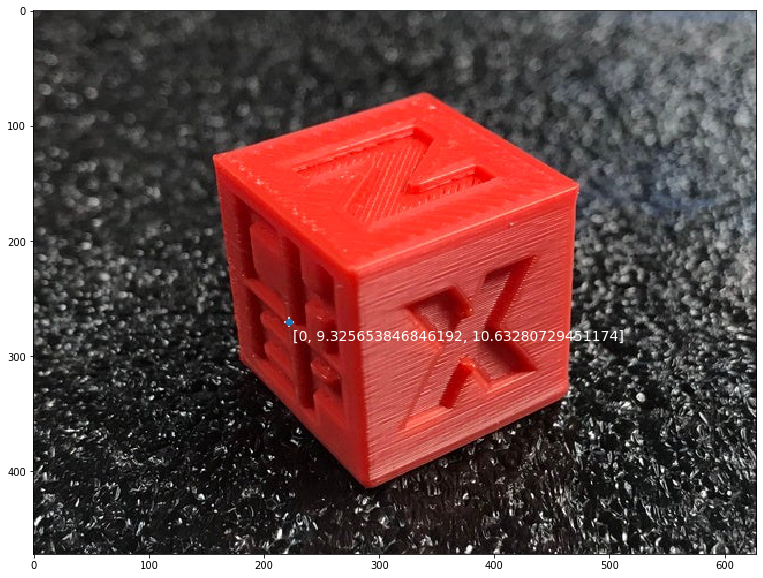

In [31]:
a = np.hstack([target_xyz, 1])
reprojected = np.dot(a, T)[:2]
plot_features([target_xyz], [reprojected], bgr=calibr_img)
plt.scatter(*target_uv)

YAY!

## For a general case you would need another view.

A bit tedious to do it, pointing features, etc. That's why you would need a GUI to point features manually and you need the physical dimensions of the object you are calibrating on. That is why OpenCV calibration is using a grid, since feature location can be automated and the grid size is known.

Also, method can be improved if camera is calibrated and intrinsic parameters are known, also if 2 views are imaged with the same camera with same intrinsic parameters and you take advantage of this knowledge (this implementation would not benefit from it). 





... 


... 

In [163]:
calibr_img2 = load_image("https://cdn.thingiverse.com/assets/43/49/a9/50/0c/large_display_CHEP_X_Cube.png")

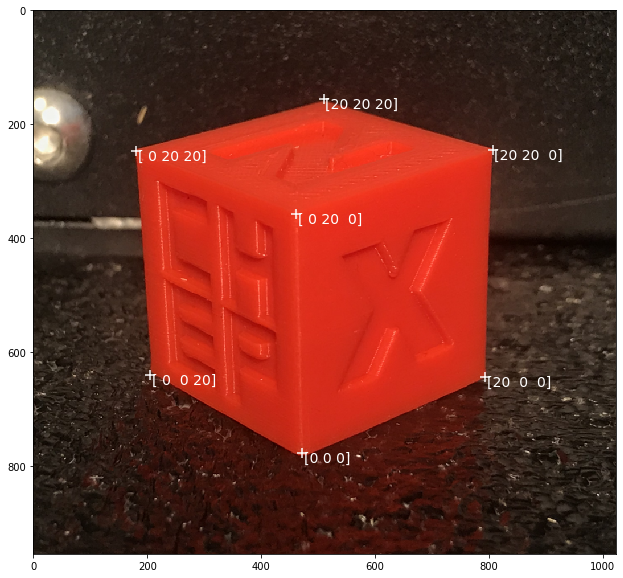

In [216]:
uv_features2 = np.array([[472, 777],
                        [794, 644],
                        [205, 640],
                        [462, 357],
                        [180, 247],
                        [807, 245],
                        [510, 155]])
plot_features(xyz_features, uv_features2, bgr=calibr_img2)

projection matrix T: 
[[ 1.64437500e+01 -5.45000000e+00 -4.02149754e-17]
 [-4.43750000e-01 -1.99750000e+01 -3.32516515e-18]
 [-1.39562500e+01 -5.50000000e+00 -1.06212275e-17]
 [ 4.73750000e+02  7.60000000e+02  1.00000000e+00]]


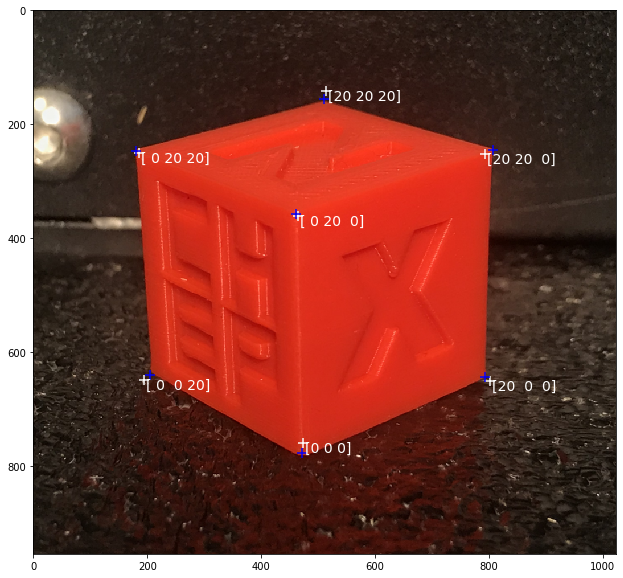

In [217]:
a2 = np.hstack([xyz_features, np.ones([len(xyz_features),1])])
b2 = np.hstack([uv_features2, np.ones([len(uv_features2),1])])

res = np.linalg.lstsq(a2, b2, rcond=0.01)
T2, residuals = res[:2]
print(f'projection matrix T: \n{T2}')

reprojected = np.dot(a2, T2)[:, :2]
plot_features(xyz_features, reprojected, bgr=calibr_img2)
for uv, xyz in zip(uv_features2, xyz_features):
    plt.scatter(uv[0], uv[1], marker='+', s=100, c='b', alpha=0.975)

Not very nice. Let's add some more features:

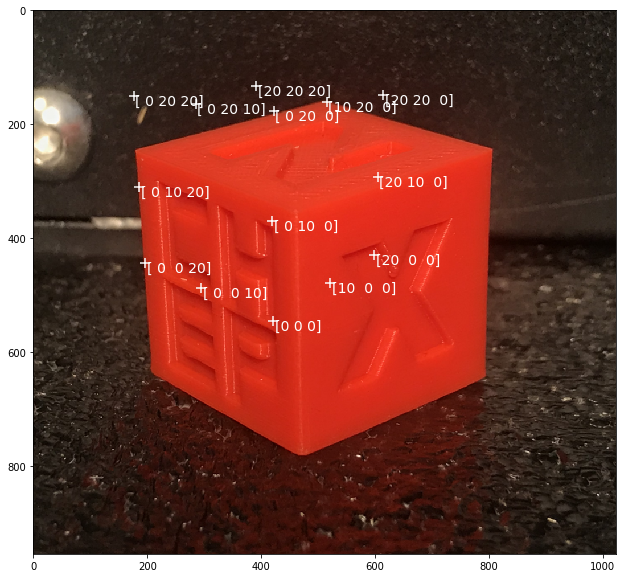

In [214]:
xyz_features2 = np.vstack([xyz_features, np.array([
    [0,0,10],
    [10,0,0],
    [0,10,0],
    [0, 10, 20],
    [0,20,10],
    [10,20,0],
    [20,10,0]
])])
uv_features2 = uv_features2 = np.array([[421, 545],
                        [599, 430],
                        [196, 443],
                        [422, 177],
                        [176, 150],
                        [615, 148],
                        [392, 132],
                        [295, 488],
                        [521, 479],
                        [420, 370],
                        [186, 310],
                        [285, 164],
                        [515, 161],
                        [605, 293]              
                                       ])
plot_features(xyz_features2, uv_features2, bgr=calibr_img2)

projection matrix T: 
[[ 9.80317460e+00 -2.60952381e+00 -3.59444409e-17]
 [-8.25396825e-02 -1.55492063e+01  2.21566138e-17]
 [-1.14682540e+01 -2.06666667e+00  9.33159995e-17]
 [ 4.16206349e+02  5.06428571e+02  1.00000000e+00]]


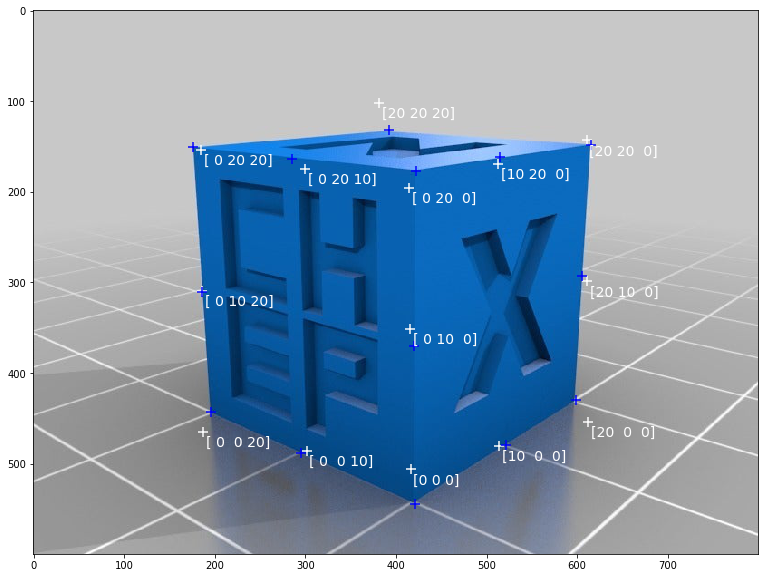

In [162]:
a2 = np.hstack([xyz_features2, np.ones([len(xyz_features2),1])])
b2 = np.hstack([uv_features2, np.ones([len(uv_features2),1])])

#a2+=np.random.rand(*a2.shape)

res = np.linalg.lstsq(a2, b2, rcond=0.01)
T2, residuals = res[:2]
print(f'projection matrix T: \n{T2}')

reprojected2 = np.dot(a2, T2)[:, :2]
plot_features(xyz_features2, reprojected2, bgr=calibr_img2)
for uv, xyz in zip(uv_features2, xyz_features2):
    plt.scatter(uv[0], uv[1], marker='+', s=100, c='b', alpha=0.975)